<center>Учреждение образования</center>
<center>«Белорусский государственный университет информатики и радиоэлектроники»</center>
<br><br>
<center>Кафедра информатики</center>
<br><br><br><br><br><br><br><br><br><br>
<center>Лабораторная работа №11</center>
<center>Реализация криптографических атак с помощью машинного обучения на физически неклонируемые функции</center>
<br><br><br><br><br><br><br><br>

<p style='text-align: right;'>
Выполнил:
Полевой Александр Вадимович <br>
магистрант кафедры информатики <br>      
группа № 858641	
<br><br><br><br>
Проверил:     Стержанов Максим Валерьевич
</p>

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

<center>
Минск 2019
</center>

**1. Изучите классическую работу У. Рурмаира о криптографических атаках с помощью машинного обучения на ФНФ** 
<br>
**2. Сформулируйте задачу в терминах машинного обучения.**

In [5]:
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [6]:
def get_data(filename, row_limit = 15000):
    ch = []
    resp = []
    
    with open(filename, 'r') as fp:
        for idx, line in enumerate(fp):
            if idx >= row_limit: break
            data = line.strip().split(' ')
            ch.append(np.asarray(list(data[0]), dtype=np.int8))
            resp.append(np.asarray(data[1], dtype=np.int8))
            
    X = np.asarray(ch)
    y = np.array(resp)
    
    return X, y

In [9]:
def der_challenge(challenges):    
    challenges_der = np.zeros(challenges.shape)
    challenges = 1 - 2 * challenges
    
    for i in range(len(challenges)):
        challenge = challenges[i]
        
        challenges_der[i][0] = challenge[0]
        
        for j in range(1, len(challenge)):
            challenges_der[i][j] = challenges_der[i][j-1] * challenge[j]
    
    return challenges_der

In [10]:
X_16b, y_16b = get_data('data/Base16.txt')

In [11]:
X_16b_der = der_challenge(X_16b)

In [12]:
np.unique(y_16b, return_counts=True)

(array([0, 1], dtype=int8), array([7236, 7764]))

**3. Обучите модель, которая могла бы предсказывать ответы по запросам, которых нет в обучающей выборке.**

In [13]:
X_16b_train, X_16b_test, y_16b_train, y_16b_test = train_test_split(X_16b_der, y_16b)

lr_model = LogisticRegression()
lr_model.fit(X_16b_train, y_16b_train)
y_16b_test_pred = lr_model.predict(X_16b_test)

print(f'Accuracy: {accuracy_score(y_16b_test, y_16b_test_pred)}')
print(f'f1: {f1_score(y_16b_test, y_16b_test_pred)}')

Accuracy: 0.992
f1: 0.9921793534932221


FileNotFoundError: [Errno 2] No such file or directory: 'data/Base64.txt'

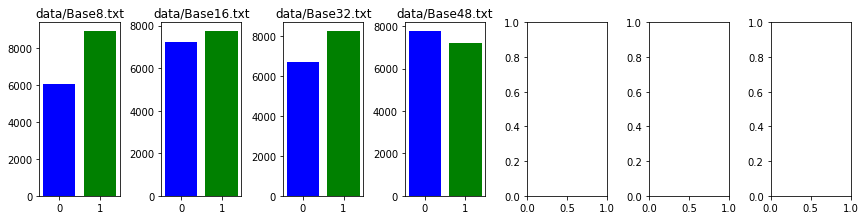

In [14]:
#to large to be pushed to github
files_balance = ['data/Base8.txt', 'data/Base16.txt', 'data/Base32.txt', 'data/Base48.txt', 'data/Base64.txt', 'data/Base96.txt', 'data/Base128.txt']
files_count = len(files_balance)
fig, axes = plt.subplots(1, files_count, figsize=(12, 3))
fig.tight_layout()
for i in range(files_count):
    ax = axes[i]
    file = files_balance[i]
    X, y = get_data(file)
    uniq = np.unique(y, return_counts=True)
    ax.bar(uniq[0], uniq[1], color=['blue', 'green'])
    ax.set_title(file)

In [ ]:
def show_data_count_dependency(filename, data_sizes):
    X, y = get_data(filename)
    X_der = der_challenge(X)
    accuracy_data = []
    for training_size in data_sizes:
        training_size = int(training_size)
    
        X_train = X_der[:training_size]
        y_train = y[:training_size]
        X_test = X_der[training_size:training_size + 3000]
        y_test = y[training_size:training_size + 3000]

        lr_model = LogisticRegression()
        svm_model = SVC()
        gb_tree_model = GradientBoostingClassifier()

        lr_model.fit(X_train, y_train)
        svm_model.fit(X_train, y_train)
        gb_tree_model.fit(X_train, y_train)

        accuracy_data.append(
            np.array([
                training_size,
                accuracy_score(y_test, lr_model.predict(X_test)),
                accuracy_score(y_test, svm_model.predict(X_test)),
                accuracy_score(y_test, gb_tree_model.predict(X_test)),
            ])
        )

    accuracy_data = np.array(accuracy_data)

    plt.figure(figsize=(12,6))

    plt.plot(accuracy_data[:,0], accuracy_data[:,1], marker='.', color='green', label='Логистическая регрессия')
    plt.plot(accuracy_data[:,0], accuracy_data[:,2], marker='.', color='blue', label='Метод опорных векторов')
    plt.plot(accuracy_data[:,0], accuracy_data[:,3], marker='.', color='orange', label='Градиентный бустинг')

    plt.title(f'На данных: {filename}')
    plt.xticks(np.linspace(np.min(data_sizes), np.max(data_sizes), 10), fontsize=10)
    
    plt.xlabel('Размер обучающей выборки', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [15]:
show_data_count_dependency('Base16.txt', np.linspace(50, 1800, 40))

NameError: name 'show_data_count_dependency' is not defined

In [16]:
show_data_count_dependency('Base64.txt', np.linspace(100, 5000, 70))

NameError: name 'show_data_count_dependency' is not defined

In [17]:
def show_N_count_dependency(files):
    accuracy_data = []
    
    for file in files:
        X, y = get_data(file)
        X_der = der_challenge(X)
        
        training_size = 10000
        X_train, X_test, y_train, y_test = train_test_split(X_der[:training_size], y[:training_size])

        lr_model = LogisticRegression()
        svm_model = SVC()
        gb_tree_model = GradientBoostingClassifier()

        lr_model.fit(X_train, y_train)
        svm_model.fit(X_train, y_train)
        gb_tree_model.fit(X_train, y_train)

        accuracy_data.append(
            np.array([
                accuracy_score(y_test, lr_model.predict(X_test)),
                accuracy_score(y_test, svm_model.predict(X_test)),
                accuracy_score(y_test, gb_tree_model.predict(X_test)),
            ])
        )
        

    accuracy_data = np.array(accuracy_data)

    plt.figure(figsize=(12,6))

    x = np.linspace(1, len(files), len(files))
    
    plt.plot(x, accuracy_data[:,0], marker='.', color='green', label='Логистическая регрессия')
    plt.plot(x, accuracy_data[:,1], marker='.', color='blue', label='Метод опорных векторов')
    plt.plot(x, accuracy_data[:,2], marker='.', color='orange', label='Градиентный бустинг')

    plt.xticks(x,files, fontsize=14)
    
    plt.xlabel('N', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

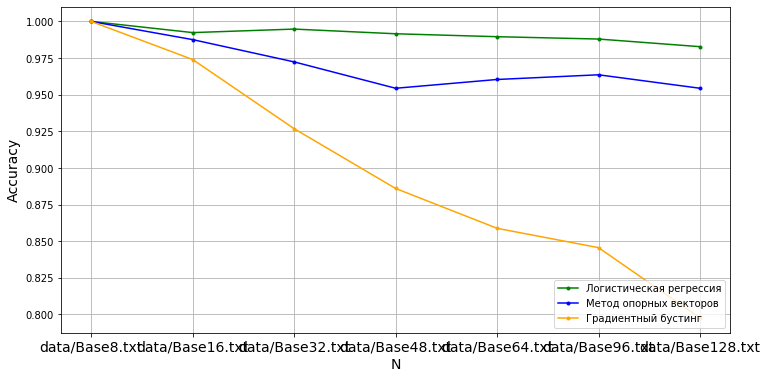

In [20]:
files = ['data/Base8.txt', 'data/Base16.txt', 'data/Base32.txt', 'data/Base48.txt', 'data/Base64.txt', 'data/Base96.txt', 'data/Base128.txt']
show_N_count_dependency(files)

**Вывод** 

Наличие стабильности подвергает ФНФ риску криптографической атаки с помощью методов машинного обучения (построения точной математической модели ФНФ)